In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import distributions as iid
import scipy.optimize as optimize
from matplotlib import pyplot as plt

In [2]:
### define data parameters, taken from the gmm_finite_samples notebook

beta = (1, 1)# "Coefficients of interest"
gamma = 2    # Governs effect of u on X
sigma_u = 1  # Note assumption of homoskedasticity
N = 1000     # no. observations

# in summary
true_params = [1, 1, 1]

In [3]:
### data generating function, 
### again taken from the gmm_finite_samples notebook
def dgp(N,beta,gamma,sigma_u):
    """Generate a tuple of (y,X,Z).

    Satisfies model:
        y = X@beta + u
        E x'u = 0
        Var(u) = sigma^2
        Cov(X,u) = gamma*sigma_u^2
        u,X mean zero, Gaussian

    Each element of the tuple is an array of N observations.

    Inputs include
    - beta :: the coefficient of interest
    - gamma :: linear effect of disturbance on X
    - sigma_u :: Variance of disturbance
    - VXZ :: Cov([X,Z|u])
    """
    
    beta = np.array(beta).reshape(2,1)
    u = iid.norm.rvs(size=(N,1))*sigma_u
    X = iid.norm.rvs(size=(N,1))

    # But X (may be) endogenous...
    X = X + gamma*u
    # add intercept
    X = np.hstack((np.ones(shape = (N,1)), X))
    # Calculate y
    y = X@beta + u

    return y,X

In [4]:
### create one data set where X is EXOGENEOUS
data_exog = dgp(N, beta, 0, sigma_u)

### create one data set where X is ENDOGENEOUS
data_endog = dgp(N, beta, gamma, sigma_u)

In [5]:
### define the moment conditions
def gj(b1, b2, s, data):
    b = np.array([b1, b2])
    y, x = data
    u  = y - x*b
    g1 = x*u
    g2 = x*u**2 - x*s**2
    
    return np.hstack((g1, g2))

In [6]:
def gN(b1, b2, s, data):
    """Averages of g_j(b).
    
    This is generic for data, to be passed to gj.
    """
    e = gj(b1, b2, s, data)
    
    # Check to see more obs. than moments.
    assert e.shape[0] > e.shape[1]
    return e.mean(axis=0)

def Omegahat(b1, b2, s, data):
    e = gj(b1, b2, s, data)

    # Recenter! We have Eu=0 under null.
    # Important to use this information.
    e = e - e.mean(axis=0) 
    return e.T@e/e.shape[0]

Winv = Omegahat(beta[0], beta[1], sigma_u, data_exog)

In [7]:
def J(b1, b2,s,W,data):
    
    m = gN(b1, b2, s, data) # Sample moments @ b, s
    N = data[0].shape[0]
    
    return N*m.T@W@m # Scale by sample size

# Limiting distribution under the null
limiting_J = iid.chi2(1)

def two_step_gmm(data):
    # First step uses identity weighting matrix
    W1 = np.eye(gj(1, 1, 1, data).shape[1])
    x0 = [1,1,1]
    
    def J2(params):
        b1, b2, s = params
        return J(b1, b2, s, W1, data)
    
    result = optimize.minimize(J2, x0)
    b10, b20, s10 = result.x
    
    # Construct 2nd step weighting matrix using
    # first step estimate of beta
    W2 = inv(Omegahat(b10, b20,s10,data))
    
    def J3(params):
        b1, b2, s = params
        return J(b1, b2, s,W2,data)
    
    return optimize.minimize(J3, result.x)

In [8]:
# get critical value when X is EXOGENEOUS
soltn = two_step_gmm(data_exog)
print("b=%f, s=%f, J=%f, Critical J=%f" % (soltn.x[0],soltn.x[1],
                                           soltn.fun,limiting_J.isf(0.05)))

b=1.039978, s=1.000281, J=0.502958, Critical J=3.841459


In [9]:
# get critical value when X is ENDOGENEOUS
soltn = two_step_gmm(data_endog)
print("b=%f, s=%f, J=%f, Critical J=%f" % (soltn.x[0],soltn.x[1],
                                           soltn.fun,limiting_J.isf(0.05)))

b=0.983544, s=1.396238, J=0.962467, Critical J=3.841459


In [10]:
# monte carlo
endog_J = []
exog_J  = []

for i in range(1000): # number of monte carlo draws
    # draw exogeneous data
    data_exog = dgp(N, beta, 0, sigma_u)
    exog_J.append(two_step_gmm(data_exog).fun)
    
    # draw endogeneous
    data_endog = dgp(N, beta, gamma, sigma_u)
    endog_J.append(two_step_gmm(data_endog).fun)

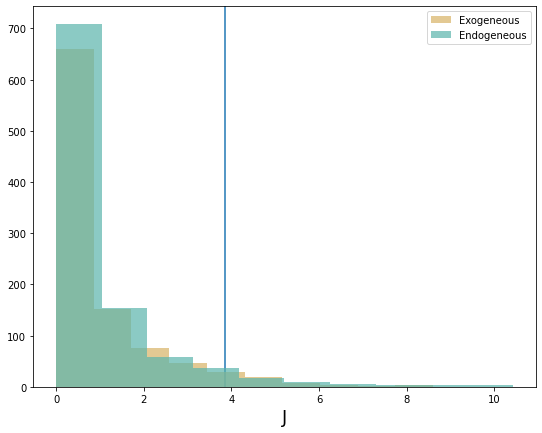

In [11]:
# plot
fig, ax = plt.subplots(figsize=(9, 7))

colors = ['#fa9fb5', '#5ab4ac']
counter = 0

plt.hist(exog_J, color = '#d8b365', alpha = 0.7, label = 'Exogeneous',zorder=10)
plt.hist(endog_J, color = '#5ab4ac', alpha = 0.7, label = 'Endogeneous',zorder=10)

plt.axvline(x = limiting_J.isf(0.05))
plt.xlabel("J", size = 18)
plt.legend()